## Proyecto de Geoinformática: árboles de busqueda

#### Autores: 
* González, Luis
* Morgado, Julio 

En esta sección se busca recrear un ejercicio de busqueda respecto a ciclovías y talleres mecánicos de bicicletas. En este sentido, buscamos respondernos si en las diferentes áreas de la ciudad hay algun tramo de ciclovia y si es que en esta misma área hay un taller en caso de una falla mecánica. El siguiente bloque presenta la paquetería requerida. 

In [1]:
#Paquetería requerida
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.neighbors import BallTree
from shapely.geometry import *
from time import process_time
import osmnx as ox
import os
import warnings
warnings.filterwarnings("ignore")

**Funciones utlizadas**

Las siguientes funciones son basicamente los diferentes buscadores variando por el número de puntos a buscar y el tipo de busqueda, si es con algún índice espacial o no. Para este caso proponemos la comparación de RTrees (http://www-db.deis.unibo.it/courses/SI-LS/papers/Gut84.pdf) y de BallTree para hacer la búsqueda de ciclovias y talleres. Por lo tanto, en los bloques de código siguientes se comparan los tiempos de busqueda variando el número de busquedas y su tipo. 

In [2]:
#Función para busqueda con índice espacial
def espacial(puntos, poligono):
    '''
    Descripción:
        Función para busqueda de puntos (puntos) en polígonos (poligono) utilizando 
        una indexación espacial mediante RTrees. 
    
    Input:
        puntos - array de puntos a buscar.
        poligono - array de poligonos a utilizar en la busqueda de puntos.
    
    Output:
        GeoDataFrame con la relación de polígonos y los puntos encontrados al interior. 
    '''
    if len(set(poligono.index.duplicated()))>1:
        print('CUIDADO, tu poligonos tienen índices repetidos')
    si = puntos.sindex
    
    pmi = []
    ide = []
    for poly in poligono.itertuples():
        c = list(si.intersection(poly.geometry.bounds))
        pmi += c
        ide += [poly.Index]*len(c)

    pm = puntos.iloc[list(set(pmi))]

    result = pm.loc[pm.intersects(poligono.unary_union)]
    result['id_busqueda'] = ide
    return result

#Función para busqueda sin índice espacial
def normal(puntos, poligono):
    '''
    Descripción:
        Función para busqueda de puntos (puntos) en polígonos (poligono) utilizando 
        intersect de pysal, sin idexación. 
    
    Input:
        puntos - array de puntos a buscar.
        poligono - array de poligonos a utilizar en la busqueda de puntos.
    
    Output:
        GeoDataFrame con la relación de polígonos y los puntos encontrados al interior. 
    '''
    pm = []
    ide = []
    for poly in poligono.itertuples():
        c = list(puntos.loc[puntos.intersects(poly.geometry)].index)
        pm += c
        ide += [poly.Index]*len(c)

    result = puntos.loc[puntos.index.isin(list(set(pm)))]
    result['id_busqueda'] = ide
    return result

# Buscador avanzado de tramo de ciclovia y si hay talleres cerca con y sin índice espacial
def buscador(tramo_ciclovia, talleres, zonas, usar_spindex=True):
    '''
    Descripción:
        Función para buscar por partes. Primero, por cuadrante (zonas), busca la existencia de 
        ciclovías al interior (tramo_ciclovia). Posteriormente, busca en el mismo cuadrante
        la existencia de talleres (talleres). La función permite utilizar o no, indexación espacial. 
    
    Input:
        tramo_ciclovia - array de tramos de ciclovia a buscar
        talleres - puntos de talleres
        zonas - array de zonas a utilizar
        usar_spindex - por default usa indexación por RTree. 
    
    Output:
        GeoDataFrame con la relación de polígonos y los puntos encontrados al interior. 
    '''
    if usar_spindex:
        step1 = espacial(tramo_ciclovia, zonas).id_busqueda.unique()
        if len(step1)>0:
            return espacial(talleres, zonas.iloc[step1, :])
        else:
            print('Lo siento, este tramo de ciclovía no está en la CDMX')
    else:
        step1 = normal(tramo_ciclovia, zonas).id_busqueda.unique()
        if len(step1)>0:
            return normal(talleres, zonas.iloc[step1, :])
        else:
            print('Lo siento, este tramo de ciclovía no está en la CDMX')     

# Buscador de taller con BallTree con un radio especifico a la redonda
def buscador_ball(tramo_ciclovia, talleres, radio):
    '''
    Descripción:
        Función de busqueda de knn utilizando indexación por BallTree. Esta función permite 
        conocer los puntos cercanos al origen; en este caso, los n talleres más cercanos 
        en un radio de n metros de las ciclovias asignadas. 
    
    Input:
        tramo_ciclovia - puntos de ciclovia a buscar.
        talleres - capa de talleres de bicis.
        radio - radio de busqueda en metros. 
    
    Output:
        c - array de tramos_ciclovia.
        t - array de puntos de talleres.
        idx - talleres asignados a punto de ciclovia en el radio especificado.
    '''
    t = np.array(list(talleres.geometry.apply(lambda x: (x.x, x.y))))
    c = np.array(list(tramo_ciclovia.geometry.apply(lambda x: (x.x, x.y))))
    btree = BallTree(t)
    idx = btree.query_radius(c, radio)
    idx = [list(x) for x in idx]
    return c, t, idx

Primero, cargamos nuestras capas de interés que son los puntos de ciclovias, tramos y talleres. Igualmente, se añade la capa del área de la CDMX para hacer las zonificaciones utilizando cuadrantes de 5km por 5km cada uno. 

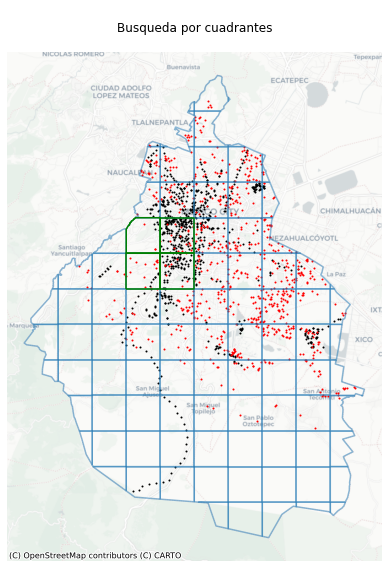

In [4]:
# Cargar áreas de la CDMX, centroides de tramos de ciclovía, red de ciclovías y talleres de bici
cdmx = gpd.read_file("data/cdmx.gpkg").to_crs(3857)[['CVE_ENT', 'geometry']]
cl = gpd.read_file('data/ciclovias_centroids_demand.gpkg').to_crs(3857)[['id_centroid','geometry']]
cll = gpd.read_file('data/ciclovias_lines.gpkg').to_crs(3857)
ta = gpd.read_file('data/Talleres_Bici.gpkg').to_crs(3857)[['id', 'geometry']]

# Crear zonas de cdmx cada 5km
cdmx_zonas = gpd.GeoDataFrame()
for i, poly in enumerate(ox.utils_geo._quadrat_cut_geometry(cdmx['geometry'][0], quadrat_width=5000)):
    cdmx_zonas = cdmx_zonas.append(gpd.GeoDataFrame(index=[i], crs=3857, geometry=[poly]))

fig, ax = plt.subplots(figsize=(8,8))
cdmx_zonas.boundary.plot(ax=ax, alpha=0.5)
cdmx_zonas.iloc[[62,63,76,77],:].boundary.plot(ax=ax, color='green')
cl.plot(ax=ax, color='black', markersize=1)
ta.plot(ax=ax, color='red', markersize=1)
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)  
ax.set_axis_off()
plt.title('\nBusqueda por cuadrantes\n')
plt.tight_layout()
plt.show()

Primero, podemos comparar la busqueda utilizando únicamente los cuadrantes y ver si hay ciclovias y talleres en su interior. Además, solo se va a usar un muestra de 4 cuadrantes. Los resultados son que hacer el índice espacial para una busqueda pequeña resulta más tardado, justo por el tema de crear el indexado. 

In [5]:
poly = cdmx_zonas.iloc[[62,63,76,77],:]

s=process_time()
espacial(cl, poly)
s1 = process_time() - s
print('Tiempo con submuestra e índice espacial: ', round(s1, 4))

s=process_time()
normal(cl, poly)
s2 = process_time() - s
print('Tiempo con submuestra SIN índice espacial: ', round(s2, 4))
print('Razón de diferencia: ', round(s2/s1-1, 2))


Tiempo con submuestra e índice espacial:  0.0312
Tiempo con submuestra SIN índice espacial:  0.0312
Razón de diferencia:  0.0


Sin embargo, si utilizamos todos los cuadrantes de la ciudad, el resultado favorece a la busqueda utilizando la indexación. 

In [6]:
s=process_time()
espacial(cl, cdmx_zonas)
s1 = process_time() - s
print('Tiempo con todos e índice espacial: ', round(s1, 4))

s=process_time()
normal(cl, cdmx_zonas)
s2 = process_time() - s
print('Tiempo con todos SIN índice espacial: ', round(s2, 4))
print('Razón de diferencia: ', round(s2/s1-1, 2))

Tiempo con todos e índice espacial:  0.2188
Tiempo con todos SIN índice espacial:  0.3438
Razón de diferencia:  0.57


Para resolver el problema que nos planteamos al inicio, ahora vamos a buscar si en el cuadrante hay ciclovía y a parte si en dicha ciclovía hay un taller cercano. 

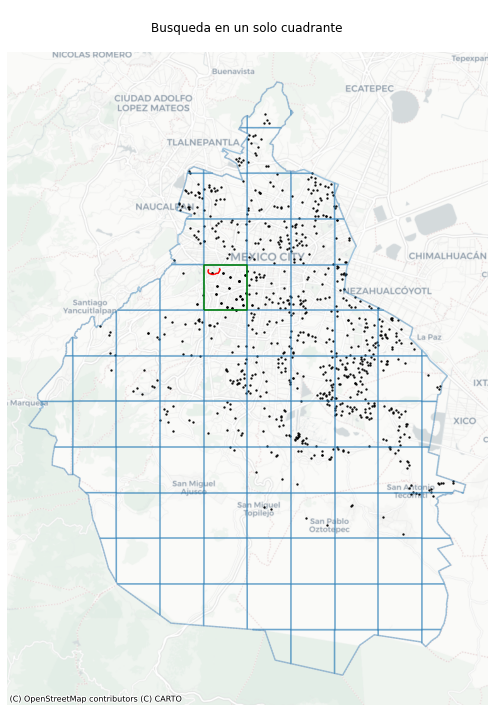

In [7]:
# Programa para buscar ciclovias y talleres
ciclovias = cl.iloc[:2,:]
resultado = buscador(ciclovias, ta, cdmx_zonas)

fig, ax = plt.subplots(figsize=(10,10))
cdmx_zonas.boundary.plot(ax=ax, alpha=0.4)
ta.plot(ax=ax, alpha=0.8, markersize=2, color='black')
cdmx_zonas.iloc[resultado.id_busqueda.unique()].boundary.plot(ax=ax, color='green')
resultado.plot(ax=ax, color='black', markersize=2)
cll.iloc[list(ciclovias.index), :].plot(ax=ax, color='red')
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)  
ax.set_axis_off()
plt.title('\nBusqueda en un solo cuadrante\n')
plt.tight_layout()
plt.show()


Igual que el ejercicio anterior, se utlizó una muestra de ciclovías y, después, toda la red para hacer la busqueda de talleres. 

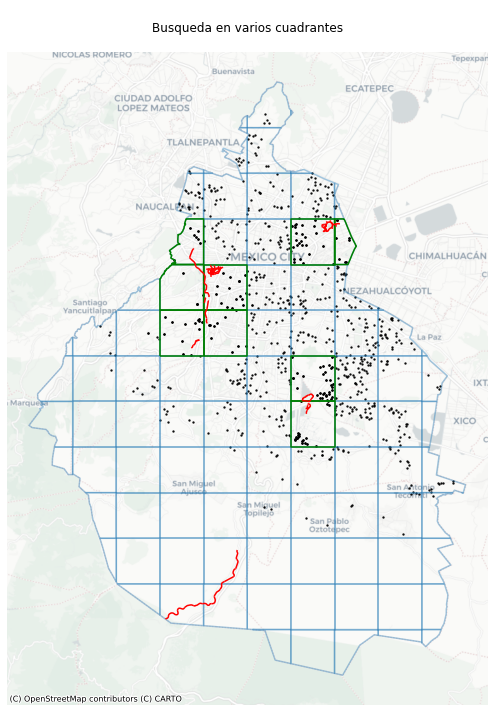

In [8]:
ciclovias = cl.iloc[:100,:]
resultado = buscador(ciclovias, ta, cdmx_zonas)

fig, ax = plt.subplots(figsize=(10,10))
cdmx_zonas.boundary.plot(ax=ax, alpha=0.4)
ta.plot(ax=ax, alpha=0.8, markersize=2, color='black')
cdmx_zonas.iloc[resultado.id_busqueda.unique()].boundary.plot(ax=ax, color='green')
resultado.plot(ax=ax, color='black', markersize=2)
cll.iloc[list(ciclovias.index), :].plot(ax=ax, color='red')
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)  
ax.set_axis_off()
plt.title('\nBusqueda en varios cuadrantes\n')
plt.tight_layout()
plt.show()

A diferencia del índice espacial anterior, también se añadió BallTree que es otra forma de hacer un árbol pero utilizando radios o *buffers*. Lo cual lo hace más interesante porque busca por cada tramo de ciclovía sus talleres más cercano de acuerdo a la distancia utilizando una indexación espacial. 

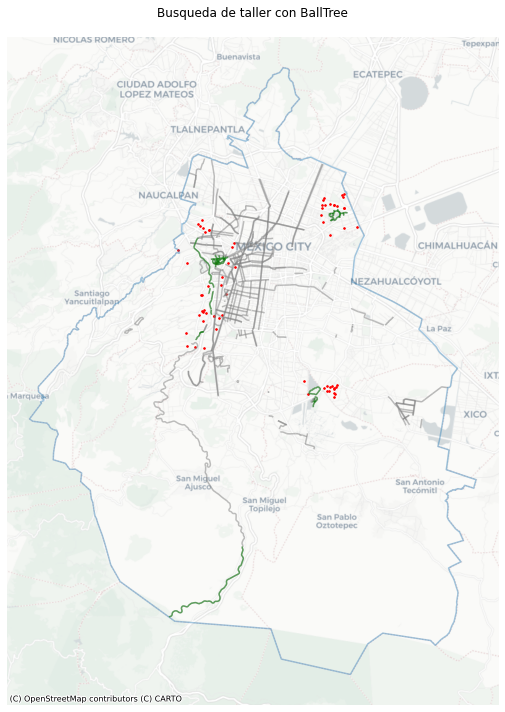

In [9]:
ciclovias = cl.iloc[:100,:]
cl_geom, _, idx = buscador_ball(ciclovias, ta, 2000)
cl_geom = [Point(x) for x in cl_geom]
idx = list(set([i for j in idx for i in j]))

fig, ax = plt.subplots(figsize=(10,10))
cll.plot(ax=ax, alpha=0.5, color='gray')
cdmx.boundary.plot(ax=ax, alpha=0.4)
cll.iloc[list(cl[cl.geometry.isin(cl_geom)].id_centroid),:].plot(ax=ax,color='green',alpha=0.5)
ta.iloc[idx, :].plot(ax=ax, color='red', markersize=2.5)
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)  
ax.set_axis_off()
plt.title('Busqueda de taller con BallTree\n')
plt.tight_layout()
plt.show()

Comparamos tiempos tanto del RTree como del BallTree en comparación con una busqueda normal. En este caso, se utiliza una toda la red de ciclovías para observar la diferencia entre busquedas. 

In [10]:

s=process_time()
buscador(cl, ta, cdmx_zonas)
s1= process_time() - s
print('Tiempo con RTree: ', round(s1, 4))

s=process_time()
buscador_ball(cl, ta, 1500)
s2= process_time() - s
print('Tiempo con BallTree: ', round(s2, 4))

s=process_time()
buscador(cl, ta, cdmx_zonas, False)
s3= process_time() - s
print('Tiempo sin índice : ', round(s3, 4))

print('Diference respecto al RTree {}, y al Ball {}'.format(round(s3/s1-1, 3), round(s3/s2-1, 3)))

Tiempo con RTree:  0.3438
Tiempo con BallTree:  0.0469
Tiempo sin índice :  0.4688
Diference respecto al RTree 0.364, y al Ball 9.0


**Conclusiones**

El objetivo del trabajo realizar de la forma más rápida y eficiente la busqueda por zonas de ciclovías en la Ciudad de México y a su vez, saber si hay talleres mecánicos de bicicletas cercanos. Para poder comparar los diferentes algoritmos se usaron tres variantes. La primera variante es la unión espacial tradicional. La segunda, es replicar la misma unión pero usando un índice espacial primero de los tramos de ciclovías. Por último, se utilizón la indexación espacial y una busqueda de knn utilizando un radio de busqueda. 

La comparación de los tres diferentes algoritmos implementa una medición de tiempo de ejecución y una razón para poder comparar dichos tiempos. Igualmente, se utilizan diferentes tamaños de muestra para observar el comportamientos de las tres variables con pocos o muchos puntos a buscar. 

En resumen del trabajo, se puede observar que el índice espacial tienen un menor tiempo de ejecución cuando se busca un mayor número de puntos. Basicamente, el usar RTree puede llegar a ser más tardado cuando hacemos pocas busquedas o tenemos muy pocos puntos para analizar. Algo interesante del segundo índice espacial implementado de BallTree fue su amplia diferencia con el RTree. Sin embargo, esto se puede esperar debido a la construcción de la función. La función de busqueda espacial realiza el trabajo en dos pasos; primero busca que en la zona haya ciclovías y después si hay talleres. En el caso de BallTree, solo se realiza una busqueda que parte de las ciclovías a los talleres más cercanos con un threshold. Por lo tanto, es aún más eficiente en la busqueda al descartar los puntos más lejanos que el threshold y quedarse con los *n* vecinos más cercanos. 

En definitiva, el uso de árboles de busqueda hacen más eficiente la consulta de datos, siempre y cuando sea una cantidad considerable. Igualmente, se debe de tomar en cuenta el tipo de árbol a construir para hacer eficiente la construcción o actualización del mismo. 